## Task 2c
To do this exercise I looked at these two sites:

- https://www.cs.toronto.edu/~lczhang/321/tut/tut06.html
- https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

### Load data
Use the MNIST dataset provided by torchvision.

In [1]:
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor

batch_size = 4

training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)
trainloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size, shuffle=True, num_workers=2)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)
testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=2)

### Train the network

Loop over the data and feed the inputs to the network and optimize. Accuracy and loss is compute for each epoch on training set and test set.

#### Optimize learning rate
Pytorch provides several methods to adjust learning rate based on the number of epochs. In this case, I use exponentialLR which decays the learning rate of each parameter group by gamma every epoch.

In [3]:
from model_task2c import PR_CNN

import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR

net = PR_CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = ExponentialLR(optimizer, gamma=0.5)

num_epochs = 10
train_losses, test_losses, train_acc, test_acc = [], [], [], []

for epoch in range(num_epochs):  # loop over the dataset multiple times
    net.train()
    running_loss = running_accuracy = total = 0.0

    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # compute loss and accuracy
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        running_accuracy += (predicted == labels).sum().item()

    # save the current training information
    train_losses.append(running_loss / len(trainloader))
    train_acc.append(running_accuracy / total)
    print(f"Train {epoch + 1} - Loss: {running_loss / len(trainloader):.3f} Accuracy: {running_accuracy / total:.3f}")

    # test model on test data
    net.eval()
    running_loss = running_accuracy = total = 0.0

    with torch.no_grad():
        for data in testloader:
            images, labels = data

            # calculate outputs by running images through the network
            outputs = net(images)

            # compute loss and accuracy
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            running_accuracy += (predicted == labels).sum().item()

        # save the current training information
        test_losses.append(running_loss / len(testloader))
        test_acc.append(running_accuracy / total)
        print(f"Test  {epoch + 1} - Loss: {running_loss / len(testloader):.3f} Accuracy: {running_accuracy / total:.3f}")

    # adjust the learning rate
    scheduler.step()

Train 1 - Loss: 0.435 Accuracy: 0.872
Test  1 - Loss: 0.329 Accuracy: 0.899
Train 2 - Loss: 0.295 Accuracy: 0.914
Test  2 - Loss: 0.231 Accuracy: 0.934
Train 3 - Loss: 0.182 Accuracy: 0.947
Test  3 - Loss: 0.169 Accuracy: 0.953
Train 4 - Loss: 0.123 Accuracy: 0.964
Test  4 - Loss: 0.135 Accuracy: 0.961
Train 5 - Loss: 0.095 Accuracy: 0.971
Test  5 - Loss: 0.108 Accuracy: 0.969
Train 6 - Loss: 0.081 Accuracy: 0.976
Test  6 - Loss: 0.101 Accuracy: 0.971
Train 7 - Loss: 0.074 Accuracy: 0.978
Test  7 - Loss: 0.101 Accuracy: 0.972
Train 8 - Loss: 0.070 Accuracy: 0.979
Test  8 - Loss: 0.098 Accuracy: 0.972
Train 9 - Loss: 0.069 Accuracy: 0.980
Test  9 - Loss: 0.097 Accuracy: 0.972
Train 10 - Loss: 0.068 Accuracy: 0.980
Test  10 - Loss: 0.097 Accuracy: 0.972


#### Graph
Plot a graph showing the accuracy and loss on the training set and the test set.

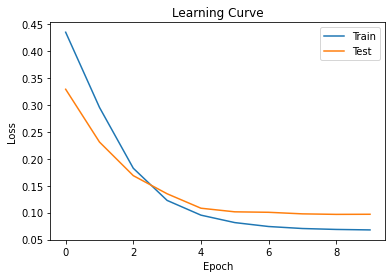

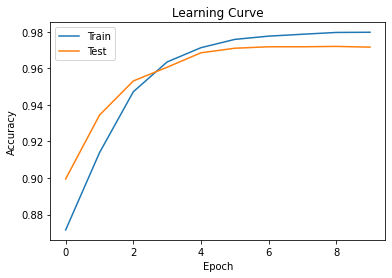

In [4]:
import matplotlib.pyplot as plt

# plotting
plt.title("Learning Curve")
plt.plot(range(num_epochs), train_losses, label="Train")
plt.plot(range(num_epochs), test_losses, label="Test")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc='best')
plt.show()

plt.title("Learning Curve")
plt.plot(range(num_epochs), train_acc, label="Train")
plt.plot(range(num_epochs), test_acc, label="Test")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc='best')
plt.show()

### Best of 5 
Perform the random initialization 5 times and save the best network based on the lowest loss value. According to PyTorch, deterministic operations are often slower than nondeterministic. Thus nothing is done here to limit the sources of randomness.

In [34]:
def get_trained_cnn(num_epochs = 10):
    net = PR_CNN()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
    scheduler = ExponentialLR(optimizer, gamma=0.5)

    train_losses = []

    for _ in range(num_epochs):  # loop over the dataset multiple times
        net.train()
        running_loss = 0.0

        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # compute loss and accuracy
            running_loss += loss.item()
            
        train_losses.append(running_loss / len(trainloader))

        # adjust the learning rate
        scheduler.step()
    
    return net, train_losses


best_net = best_loss = None
for i in range(5):
    net, losses = get_trained_cnn(8)
    loss = losses[-1]
    print(f"{i + 1} Loss: {loss}")
    if not best_loss or loss < best_loss:
        best_net = net
        best_loss = loss

PATH = './net.pth'
torch.save(best_net.state_dict(), PATH)

1 Loss: 0.09183126728979116
2 Loss: 0.07217693782344474
3 Loss: 0.06971510876387313
4 Loss: 0.06781262266746359
5 Loss: 0.0672595200346859


Test accuracy with the best net found.

In [38]:
net = PR_CNN()
net.load_state_dict(torch.load(PATH))

correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the {len(test_data)} test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 97 %
